# classification-04

## What's new:

1- increase labels

## next step:

1- Improve labeling ( 3333 from 28-1111 )


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
import talib


2025-10-29 17:34:39.082870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 17:34:39.105800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

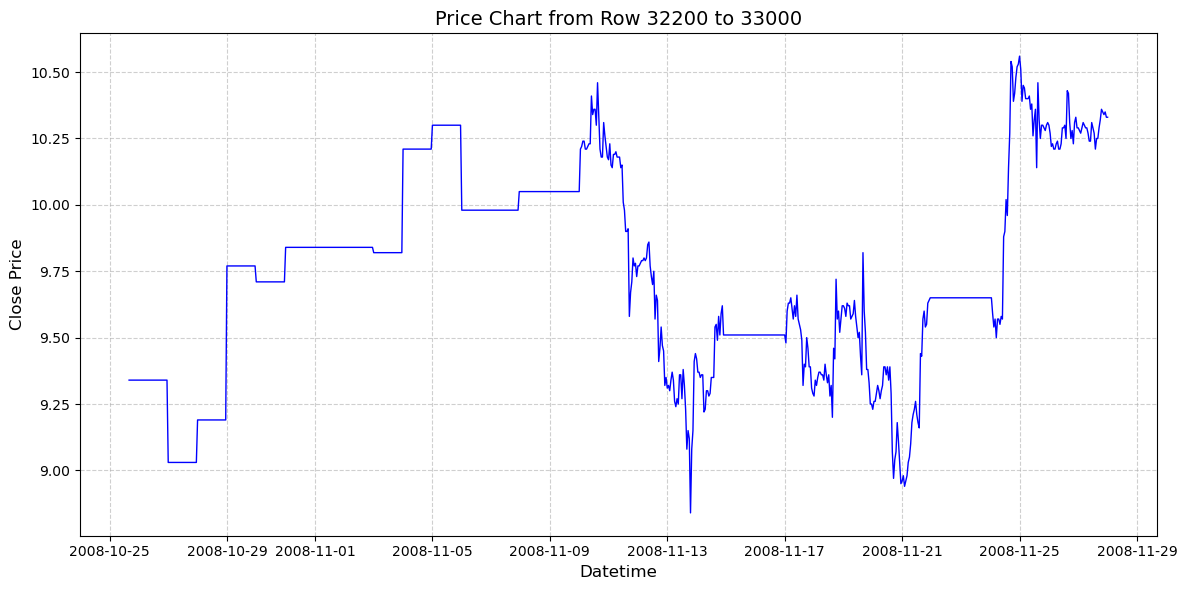

In [4]:
import matplotlib.pyplot as plt

# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000   # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500   # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df)-mm].reset_index(drop=True)

In [6]:
def label_reversal_points(prices, window=6, threshold=0.0007):
    """
    Labels trend reversals (1=Buy, 2=Sell) based on local mean shifts.
    Smaller window & threshold increase sensitivity.
    """
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect reversal only when trend flips clearly
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell

        if curr_trend != 0:
            prev_trend = curr_trend

    return labels

df_model['Label'] = label_reversal_points(df_model['CLOSE'].values)

In [7]:
print(df_model['Label'].value_counts().sort_index())  # 0, 1, 2

Label
0    130688
1      7834
2      7834
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt

def plot_labeled_candles(df, n=190):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



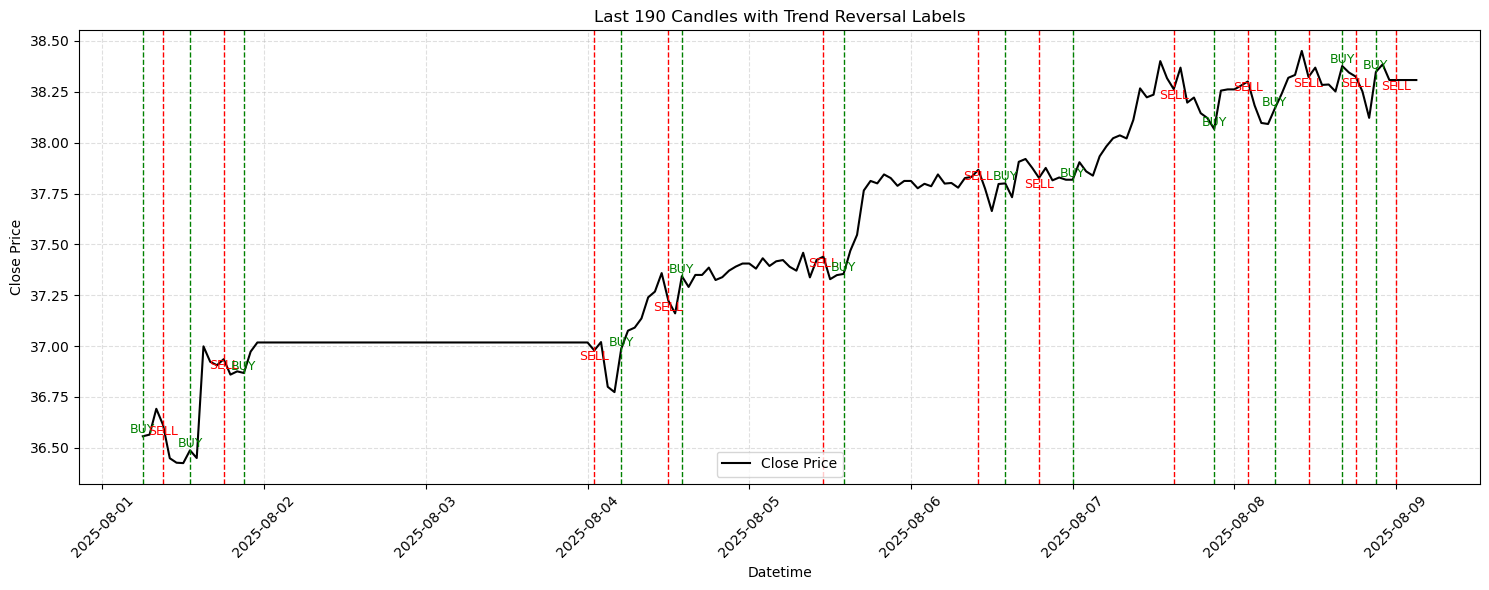

In [9]:
plot_labeled_candles(df_model)

In [10]:

WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN','HIGH','LOW','CLOSE','TICKVOL']


In [11]:
# 1) build sequences
scaled_full = df_model[FEATURES].values  # don't fit scaler yet
labels_full = df_model['Label'].values

# Choose contiguous splits: train/val/test by index
n = len(df_model)
test_size = int(n * 0.05)       # 5% test (tweak)
val_size = int(n * 0.05)        # 5% val
train_size = n - val_size - test_size

# sequences helper
def make_sequences(features_arr, labels_arr):
    X, y = [], []
    for i in range(WINDOW_SIZE, len(features_arr) - FORECAST_HORIZON + 1):
        X.append(features_arr[i-WINDOW_SIZE:i])
        y.append(labels_arr[i:i+FORECAST_HORIZON])
    return np.array(X), np.array(y)

# Build index-based splits BEFORE scaling to avoid leakage
# We'll convert index ranges to sequence ranges
# Compute sequence start index mapping: sequence i corresponds to center index i (end index)
seq_start = WINDOW_SIZE
seq_end = n - FORECAST_HORIZON + 1
# compute sequence array indices that fall entirely in train/val/test regions
seq_indices = np.arange(seq_start, seq_end)  # these correspond to "i" in your original loop

train_mask = seq_indices < train_size
val_mask   = (seq_indices >= train_size) & (seq_indices < train_size + val_size)
test_mask  = seq_indices >= (train_size + val_size)

# Now fit scaler on training rows only (rows used by train sequences)
# Determine training rows that will be used: for sequence ending at i, used rows are i-WINDOW_SIZE .. i-1
train_row_start = 0
train_row_end = train_size + WINDOW_SIZE  # conservative
scaler = MinMaxScaler()
scaler.fit(df_model.loc[:train_row_end-1, FEATURES].values)  # only training portion

scaled_all = scaler.transform(df_model[FEATURES].values)
X_all, y_all = make_sequences(scaled_all, labels_full)

In [12]:

X_train = X_all[train_mask]
y_train = y_all[train_mask]
X_val   = X_all[val_mask]
y_val   = y_all[val_mask]
X_test  = X_all[test_mask]
y_test  = y_all[test_mask]

# one-hot encode
y_train_oh = np.array([to_categorical(seq, num_classes=3) for seq in y_train])
y_val_oh   = np.array([to_categorical(seq, num_classes=3) for seq in y_val])
y_test_oh  = np.array([to_categorical(seq, num_classes=3) for seq in y_test])

# build sample_weight to emphasize non-zero labels
# give weight 1 to class 0 and weight 5 to classes 1/2 (tune alpha)
alpha = 5.0
sw_train = np.where(y_train == 0, 1.0, alpha).astype(float)   # shape (samples, timesteps)
sw_val   = np.where(y_val == 0, 1.0, alpha).astype(float)

# build encoder-decoder LSTM
enc_input = Input(shape=(WINDOW_SIZE, len(FEATURES)))
enc = LSTM(128, return_sequences=False)(enc_input)
enc = Dropout(0.25)(enc)
dec = RepeatVector(FORECAST_HORIZON)(enc)
dec = LSTM(128, return_sequences=True)(dec)
dec = Dropout(0.2)(dec)
out = TimeDistributed(Dense(64, activation='relu'))(dec)
out = TimeDistributed(Dense(3, activation='softmax'))(out)

model = Model(enc_input, out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train_oh,
          epochs=50,
          batch_size=128,
          validation_data=(X_val, y_val_oh, sw_val),
          sample_weight=sw_train,   # Keras accepts sample_weight for (samples,) or (samples, timesteps)
          callbacks=[es],
          shuffle=False)

Epoch 1/50
   1/1029 ━━━━━━━━━━━━━━━━━━━━ 37:16 2s/step - accuracy: 0.0969 - loss: 1.9231

2025-10-29 17:35:59.473891: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.8919 - loss: 1.3124 - val_accuracy: 0.8952 - val_loss: 1.2230
Epoch 2/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.8924 - loss: 1.2612 - val_accuracy: 0.8952 - val_loss: 1.2360
Epoch 3/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.8926 - loss: 1.2401 - val_accuracy: 0.8952 - val_loss: 1.2047
Epoch 4/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.8926 - loss: 1.2303 - val_accuracy: 0.8952 - val_loss: 1.2106
Epoch 5/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.8926 - loss: 1.2241 - val_accuracy: 0.8952 - val_loss: 1.2022
Epoch 6/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.8926 - loss: 1.2479 - val_accuracy: 0.8952 - val_loss: 1.2113
Epoch 7/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 51s 50ms/step - accuracy: 0.8926 - loss: 1.2247 - val_accuracy: 0.8952 - val_loss: 1.2067
Epoch 8/50
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.8926 - loss: 1.25

In [13]:
# --------------------------
# === Prediction Block ===
# --------------------------
import numpy as np
import pandas as pd

FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# --- Given datetime (must exactly match format in DATETIME column) ---
given_time = "2025.07.24 11:00:00"   # note: space, not tab

# --- Find the index of the given datetime ---
given_time_dt = pd.to_datetime(given_time)
start_idx_list = df.index[df['DATETIME'] == given_time_dt].tolist()

if not start_idx_list:
    raise ValueError(f"Given time {given_time} not found in DATETIME column.")
start_idx = start_idx_list[0]

# --- Extract last 60 candles ending at given_time ---
# (If you want the model to predict *after* those 60, we take the 60 rows up to the given_time)
if start_idx < WINDOW_SIZE:
    raise ValueError("Not enough history before the given_time for 60-candle input.")

input_df = df.iloc[start_idx - WINDOW_SIZE:start_idx].copy()

# --- Prepare and scale features using the SAME scaler from training ---
input_features = input_df[FEATURES].values
input_scaled = scaler.transform(input_features)     # shape: (60, 5)
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# --- Predict ---
pred_probs = model.predict(input_sequence, verbose=0)   # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)         # shape: (10,)

print("Predicted Classes (0=no signal, 1=buy, 2=sell):", pred_classes)

# --- Generate future timestamps for the 10-hour forecast ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

# --- Build output DataFrame ---
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


Predicted Classes (0=no signal, 1=buy, 2=sell): [0 0 0 0 0 0 0 0 0 0]
             DATETIME  forecast_class label
0 2025-07-24 11:00:00               0      
1 2025-07-24 12:00:00               0      
2 2025-07-24 13:00:00               0      
3 2025-07-24 14:00:00               0      
4 2025-07-24 15:00:00               0      
5 2025-07-24 16:00:00               0      
6 2025-07-24 17:00:00               0      
7 2025-07-24 18:00:00               0      
8 2025-07-24 19:00:00               0      
9 2025-07-24 20:00:00               0      


# plot section

In [14]:
# --------------------------
# === Visualization Block ===
# --------------------------
import pandas as pd
import sys

# --- 1. Historical window (last 4 real candles before forecast) ---
historical_df = input_df.tail(4).copy()

# --- 2. Actual future 10 candles (if available in df) ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = start_idx
actual_future_end = start_idx + FORECAST_HORIZON
actual_future_df = df.iloc[actual_future_start -1 :actual_future_end].copy()

# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})

# --- 4. Add text labels for clarity ---
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



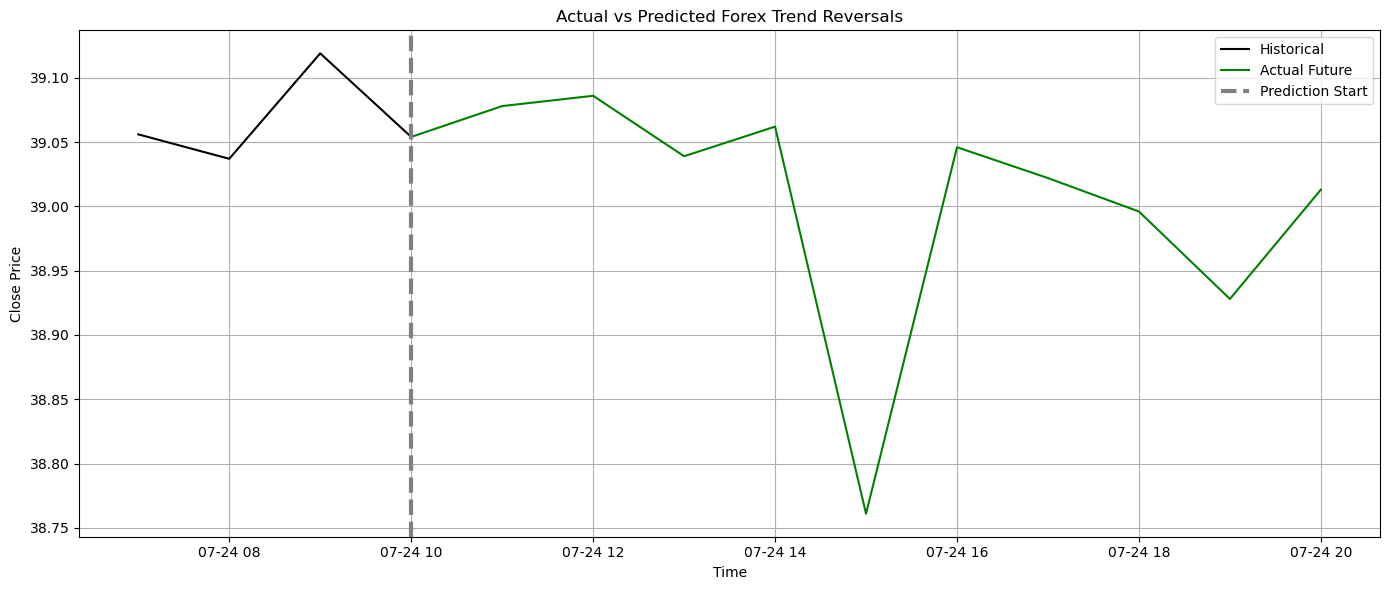

In [15]:
# --- 6. Import your plotting utility ---
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [16]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

In [ ]:
from tensorflow import keras
model = keras.models.load_model(
    'saved_models/model_20251029_182023.keras',
    safe_mode=False
)
